# Import Packages

In [1]:
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# Downscale

In [2]:
# Register GDAL format drivers and configuration options with a context manager.
def downscale_geo_tiff_by_factor(input_img_path,output_img_path,scale_factor=3):
    with rasterio.Env():
        with rasterio.open(input_img_path) as input_dataset:
            # scale image transform
            transform = input_dataset.transform * input_dataset.transform.scale(
                scale_factor,  # rows
                scale_factor  # cols
            )
            out_shape=(int(input_dataset.height/scale_factor), int(input_dataset.width/scale_factor))
            profile = input_dataset.profile
            profile.update(transform=transform, width=out_shape[1], height=out_shape[0])
            band_number = input_dataset.read().shape[0]
            with rasterio.open(output_img_path, 'w', **profile) as output_dataset:
                for i in range(band_number):
                    data = input_dataset.read(i+1, out_shape=out_shape, resampling=Resampling.bilinear)
                    output_dataset.write(data, i+1)

In [3]:
# Input file name structure
data_path = "../raw_data/wc2021-2040/"
gcm_model_name = "ACCESS-CM2"
ssp_model_names = ["ssp126","ssp585"]
feature_names = ["tmin","tmax","prec","bioc"]

In [5]:
%%time
# Downscale multi-band geotifs
for feature_name in feature_names:
    for ssp_model_name in ssp_model_names:
        file_name = 'wc2.1_10m_'+feature_name+'_'+gcm_model_name+'_'+ssp_model_name+'_2021-2040.tif'
        input_path = data_path+file_name
        output_path = input_path[:-4]+"_downscaled"+input_path[-4:]
        downscale_geo_tiff_by_factor(input_path,output_path)

CPU times: user 9.25 s, sys: 552 ms, total: 9.8 s
Wall time: 9.97 s


In [6]:
# Downscale test on 'wc2.1_10m_bioc_ACCESS-CM2_ssp126_2021-2040.tif'
input_img_path = '../raw_data/wc2021-2040/wc2.1_10m_bioc_ACCESS-CM2_ssp126_2021-2040.tif'
output_img_path = input_img_path[:-4]+"_downscaled"+input_img_path[-4:]
# downscale_geo_tiff_by_factor(input_img_path,output_img_path)

# Check shapes
with rasterio.open(input_img_path) as input_img_dataset:
        input_img_read = input_img_dataset.read()

with rasterio.open(output_img_path) as output_img_dataset:
        output_img_read = output_img_dataset.read()

print(input_img_read.shape,"\n",output_img_read.shape)

(19, 1080, 2160) 
 (19, 360, 720)


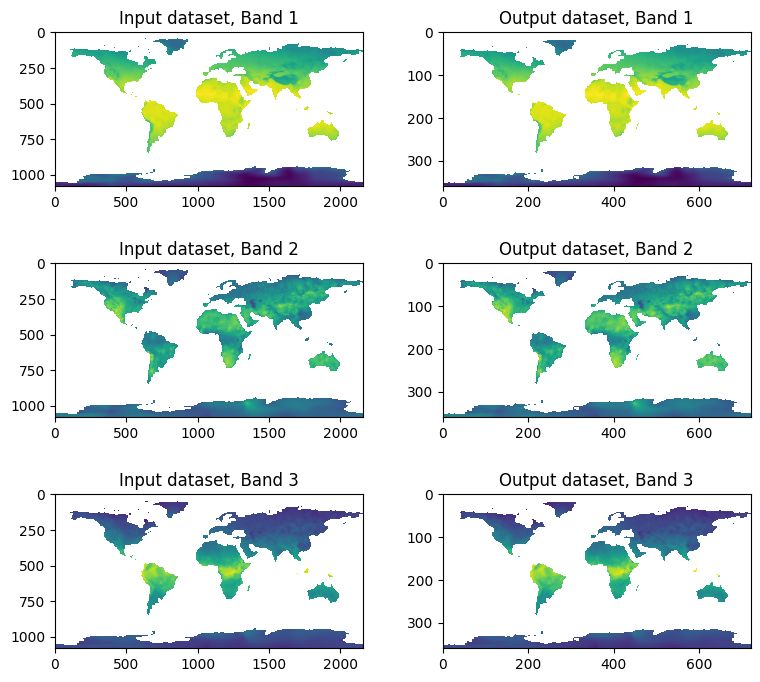

In [7]:
# Plot input / output
fig, axs = plt.subplots(3,2, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.set_figheight(8)
fig.set_figwidth(10)
axs = axs.ravel()

axs[0].imshow(input_img_read[0,:,:])
axs[0].set_title("Input dataset, Band 1")
axs[1].imshow(output_img_read[0,:,:])
axs[1].set_title("Output dataset, Band 1")

axs[2].imshow(input_img_read[1,:,:])
axs[2].set_title("Input dataset, Band 2")
axs[3].imshow(output_img_read[1,:,:])
axs[3].set_title("Output dataset, Band 2")

axs[4].imshow(input_img_read[2,:,:])
axs[4].set_title("Input dataset, Band 3")
axs[5].imshow(output_img_read[2,:,:])
axs[5].set_title("Output dataset, Band 3");

# Comparing feature values of two datasets

In [8]:
# Getting feature values from spatial data sets
# The following function retrieves the values for given lat/lon
def getvalue(data, lat, lon, band=0):
    data_array = data.read()[band]
    # since the raster is in regular lon/lat grid, we can use 
    # `data.index()` to identify the index of a given lon/lat pair
    idx = data.index(lon, lat, precision=1E-6)    
    return data_array[idx]

In [9]:
plant_data_inkl_bioclim = pd.read_csv("../raw_data/plant_data_inkl_bioclim/plant_data_inkl_bioclim_101.csv")
test_coordinates = plant_data_inkl_bioclim.sample(n=10)[["decimalLatitude","decimalLongitude"]]

In [10]:
with  rasterio.open(input_img_path) as input_img:
    with rasterio.open(output_img_path) as output_img:
        test_coordinates["bioc01_original"] = getvalue(
            input_img,test_coordinates["decimalLatitude"],test_coordinates["decimalLongitude"])
        test_coordinates["bioc01_downsampled"] = getvalue(
            output_img,test_coordinates["decimalLatitude"],test_coordinates["decimalLongitude"])
        
        test_coordinates["bioc07_original"] = getvalue(
            input_img,test_coordinates["decimalLatitude"],test_coordinates["decimalLongitude"],band=6)
        test_coordinates["bioc07_downsampled"] = getvalue(
            output_img,test_coordinates["decimalLatitude"],test_coordinates["decimalLongitude"],band=6)
        
test_coordinates

/root/.pyenv/versions/3.10.6/envs/planetary_garden/lib/python3.10/site-packages/rasterio/transform.py:127: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/root/.pyenv/versions/3.10.6/envs/planetary_garden/lib/python3.10/site-packages/rasterio/transform.py:127: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/root/.pyenv/versions/3.10.6/envs/planetary_garden/lib/python3.10/site-packages/rasterio/transform.py:127: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
/root/.pyenv/versions/3.10.6/envs/planetary_garden/lib/python3.10/site-packages/rasterio/transform.py:127: RasterioDeprecationWarning: The precision parameter is unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


,decimalLatitude,decimalLongitude,bioc01_original,bioc01_downsampled,bioc07_original,bioc07_downsampled
173915,59.887200,17.350800,7.800000,8.095062,28.900000,28.892591
128444,-28.166667,17.033333,21.299999,21.930864,22.900000,23.967901
93587,-16.655594,-49.217439,24.900000,24.613581,16.799999,17.004938
72372,-4.216667,12.500000,25.000000,25.879013,12.600000,12.944445
143211,12.700883,120.885817,27.200001,NaN,11.200000,NaN
48203,-26.750000,28.200000,17.500000,17.541975,27.500000,27.440741
164104,37.831670,-122.186700,NaN,NaN,NaN,NaN
175465,38.248336,-122.957164,15.000000,NaN,23.100000,NaN
65683,25.112530,-110.509490,NaN,NaN,NaN,NaN
95852,-28.998530,25.092539,19.600000,19.309875,32.400002,32.543209


# Other downscaling methods

In [ ]:
# !pip install tifffile
# !pip install scikit-image
# !pip install imagecodecs
from tifffile import imread, imwrite
from skimage.transform import resize
import imagecodecs

data = imread(data_path+'wc2.1_10m_bioc_ACCESS-CM2_ssp126_2021-2040.tif')

resized_data = resize(data, (375, 500, 21))
imwrite('multi-channel_resized.tif', resized_data, planarconfig='CONTIG')